In [5]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
table = read_csv('/content/drive/MyDrive/QuadrantiCremona.csv')
table.head()

Unnamed: 0        Date  Ammonia  PM10  PM25  Wind_speed  Temperature  \
0           0  2014-02-12      6.5  54.0  44.0    0.479634     8.004167   
1           1  2014-02-13      8.3  52.0  43.0    1.035337     5.375000   
2           2  2014-02-14      7.7  43.0  36.0    1.061836     7.508333   
3           3  2014-02-15      9.6  41.0  35.0    0.452648     6.404167   
4           4  2014-02-16      7.4  67.0  59.0    0.771591     7.554167   

   Rainfall  Quadrante  
0       0.0          2  
1       0.6          1  
2       0.0          4  
3       0.0          4  
4       0.2          4

In [8]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
#PM 2.5 were removed
Moggio = table.loc[:,["Date","PM10","Ammonia","Wind_speed","Quadrante","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:-365,:] # we train not using 2020, for now
Moggio.head()


index        Date  PM10  Ammonia  Wind_speed  Quadrante  Temperature  \
0      0  2014-02-12  54.0      6.5    0.479634          2     8.004167   
1      1  2014-02-13  52.0      8.3    1.035337          1     5.375000   
2      2  2014-02-14  43.0      7.7    1.061836          4     7.508333   
3      3  2014-02-15  41.0      9.6    0.452648          4     6.404167   
4      4  2014-02-16  67.0      7.4    0.771591          4     7.554167   

   Rainfall  
0       0.0  
1       0.6  
2       0.0  
3       0.0  
4       0.2

In [9]:
# sns.lineplot(x='Date', y='PM25', data=Moggio)

##Convert series to supervised learning
### Activation function = tanh and logistic (s curve)

###Conversion Function

In [10]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Conversion of Moggio

In [11]:
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[31,32,33,34,35]], axis=1, inplace=True)

reframed.head()

var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  var5(t-5)  var6(t-5)  \
5   0.292398   0.155388   0.124610   0.333333   0.310002   0.000000   
6   0.280702   0.200501   0.270771   0.000000   0.234159   0.007426   
7   0.228070   0.185464   0.277741   1.000000   0.295699   0.000000   
8   0.216374   0.233083   0.117512   1.000000   0.263847   0.000000   
9   0.368421   0.177945   0.201400   1.000000   0.297021   0.002475   

   var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  ...  var4(t-2)  var5(t-2)  \
5   0.280702   0.200501   0.270771        0.0  ...        1.0   0.263847   
6   0.228070   0.185464   0.277741        1.0  ...        1.0   0.297021   
7   0.216374   0.233083   0.117512        1.0  ...        1.0   0.327070   
8   0.368421   0.177945   0.201400        1.0  ...        0.0   0.273824   
9   0.292398   0.180451   0.208162        1.0  ...        1.0   0.324666   

   var6(t-2)  var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  \
5   0.000000   0.368421   0.177945   0.201400   1.000000   0.297021   
6   0.002475   0.292398   0.180451   0.208162   1.000000   0.327070   
7   0.044554   0.298246   0.235589   0.028907   0.000000   0.273824   
8   0.000000   0.181287   0.215539   0.210324   1.000000   0.324666   
9   0.113861   0.099415   0.135338   0.120864   0.333333   0.335724   

   var6(t-1)   var1(t)  
5   0.002475  0.292398  
6   0.044554  0.298246  
7   0.000000  0.181287  
8   0.113861  0.099415  
9   0.044554  0.216374  

[5 rows x 31 columns]

In [12]:
# split into train and test sets
values = reframed.values
n_features = 6 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1312, 30) 1312 (1312,)
(1312, 5, 6) (1312,) (633, 5, 6) (633,)


# Modeling and training

Epoch 1/500
14/14 - 8s - loss: 0.1281 - val_loss: 0.0966 - 8s/epoch - 593ms/step
Epoch 2/500
14/14 - 0s - loss: 0.0957 - val_loss: 0.0761 - 297ms/epoch - 21ms/step
Epoch 3/500
14/14 - 0s - loss: 0.0849 - val_loss: 0.0750 - 288ms/epoch - 21ms/step
Epoch 4/500
14/14 - 0s - loss: 0.0821 - val_loss: 0.0724 - 283ms/epoch - 20ms/step
Epoch 5/500
14/14 - 0s - loss: 0.0791 - val_loss: 0.0692 - 292ms/epoch - 21ms/step
Epoch 6/500
14/14 - 0s - loss: 0.0778 - val_loss: 0.0680 - 285ms/epoch - 20ms/step
Epoch 7/500
14/14 - 0s - loss: 0.0773 - val_loss: 0.0679 - 286ms/epoch - 20ms/step
Epoch 8/500
14/14 - 0s - loss: 0.0777 - val_loss: 0.0681 - 284ms/epoch - 20ms/step
Epoch 9/500
14/14 - 0s - loss: 0.0772 - val_loss: 0.0672 - 283ms/epoch - 20ms/step
Epoch 10/500
14/14 - 0s - loss: 0.0756 - val_loss: 0.0663 - 299ms/epoch - 21ms/step
Epoch 11/500
14/14 - 0s - loss: 0.0752 - val_loss: 0.0661 - 286ms/epoch - 20ms/step
Epoch 12/500
14/14 - 0s - loss: 0.0757 - val_loss: 0.0662 - 293ms/epoch - 21ms/step
Epo

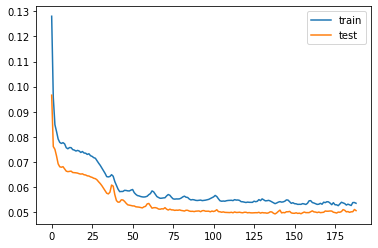

In [13]:
# design the neural network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=50, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=500, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=early_stopping)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Predictions of the year 2019

In [14]:
# make a prediction
yhat = model.predict(test_X)
#Convert from 3D to 2D
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1) # the last 5 so that we have all 5 of the predictors in only one lag (and not all the 5 lags)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 11.082


#### Prediciton plots

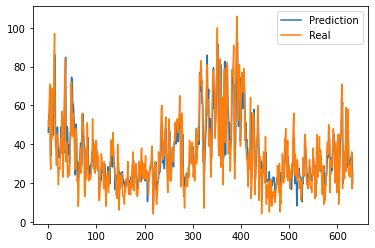

In [15]:
pyplot.plot(inv_yhat, label = 'Prediction')
pyplot.plot(inv_y, label = 'Real')
pyplot.legend()
pyplot.show()

prediction with 2020

In [16]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
#PM 2.5 were removed
Moggio = table.loc[:,["Date","PM10","Ammonia","Wind_speed","Quadrante","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:,:] # this is the differrence!!!!
Moggio.head()
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[31,32,33,34,35]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
n_features = 6 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(1312, 30) 1312 (1312,)
(1312, 5, 6) (1312,) (998, 5, 6) (998,)


In [17]:
# make a prediction
yhat = model.predict(test_X)
#Convert from 3D to 2D
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 11.316


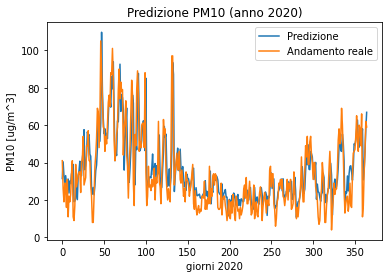

In [18]:
pyplot.plot(inv_yhat[-365:], label = 'Predizione')
pyplot.plot(inv_y[-365:], label = 'Andamento reale')
pyplot.legend()
pyplot.title("Predizione PM10 (anno 2020)")
pyplot.xlabel('giorni 2020') 
pyplot.ylabel('PM10 [ug/m^3]') 
pyplot.show()

# LIME

In [19]:
!pip install lime

In [20]:
from lime import lime_tabular

In [21]:
test_X.shape
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

In [22]:
explainer = lime_tabular.RecurrentTabularExplainer(test_X, feature_names=["PM10","Ammonia","Wind_speed","Wind_direction","Temperature","Rainfall"], mode='regression')

In [23]:
exp = explainer.explain_instance(test_X[50], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()
# values are the actual values of the features for that given day

In [24]:
exp = explainer.explain_instance(test_X[49], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [25]:
exp = explainer.explain_instance(test_X[75], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [26]:
test_X[1]

array([[0.13450292, 0.09774435, 0.250394  , 0.33333334, 0.39552075,
        0.11138613],
       [0.18128654, 0.0726817 , 0.16620198, 1.        , 0.29397625,
        0.        ],
       [0.21052632, 0.0802005 , 0.06799596, 1.        , 0.28321883,
        0.00495049],
       [0.23976609, 0.07769424, 0.06257708, 0.        , 0.2630862 ,
        0.00247525],
       [0.28070176, 0.0651629 , 0.13409364, 1.        , 0.16781187,
        0.        ]], dtype=float32)

In [27]:
exp.as_list()

[('Rainfall_t-0 <= 0.00', 0.030697086897801904),
 ('Wind_speed_t-0 > 0.20', -0.014957291325892902),
 ('Ammonia_t-0 > 0.22', -0.01312797829524878),
 ('Ammonia_t-1 > 0.22', 0.008502784479809804),
 ('Rainfall_t-3 <= 0.00', -0.0062429263603848185),
 ('Wind_direction_t-0 <= 0.00', -0.005546904751761732)]